# Modeling and Feature Engineering

In [123]:
import pandas as pd
import numpy as np
import pickle
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import patsy

Read pickle:

In [124]:
movies_df = pd.read_pickle('movies_df_no_outliers.pkl')
movies_genre_df = pd.read_pickle('movies_genre_df_no_outliers.pkl')

## Baseline
Look at one feature (you might get lucky and this is THE feature needed to explain your observations). You can see the fit immediately from the seaborn plot. Run statsmodels or sklearn to look at R^2, etc

Baseline model & OLS regression summary stats

Let's pick production budget as the single feature for the baseline model:

In [125]:
X = movies_df.loc[:,['production_budget']]
y = movies_df['domestic_gross']

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=1)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
#                                                  test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2                                                 

In [127]:
print(X_train.shape, X_test.shape)

(2505, 1) (627, 1)


In [128]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     1622.
Date:                Sun, 19 Apr 2020   Prob (F-statistic):          8.09e-274
Time:                        14:06:31   Log-Likelihood:                -48106.
No. Observations:                2505   AIC:                         9.622e+04
Df Residuals:                    2503   BIC:                         9.623e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.648e+07   1.49e+06     11.047      0.000    1.36e+07    1.94e+07
production_budget     0.9403      0.023     40.271      0.000       0.894       0.986
==============================================================================
Omnibus:                     1139.953   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8157.151
Skew:                           2.017   Prob(JB):                         0.00
Kurtosis:                      10.866   Cond. No.                     9.01e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.01e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Residual plot:

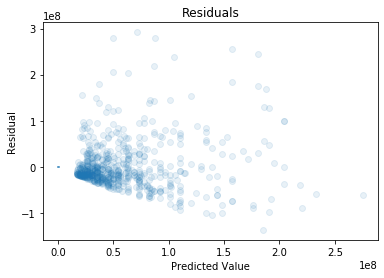

In [129]:
y_pred = results.predict(sm.add_constant(X_test))

plt.scatter(y_pred,y_test-y_pred,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,0,1000))
plt.title('Residuals')
plt.xlabel('Predicted Value')
plt.ylabel('Residual');

In [130]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    # Plot fit 
    plt.subplot(1, 3, 1)
    plt.scatter(x,y, alpha=0.1)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    # Plot residuals
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res, alpha=0.1)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    # Plot Q-Q plot
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

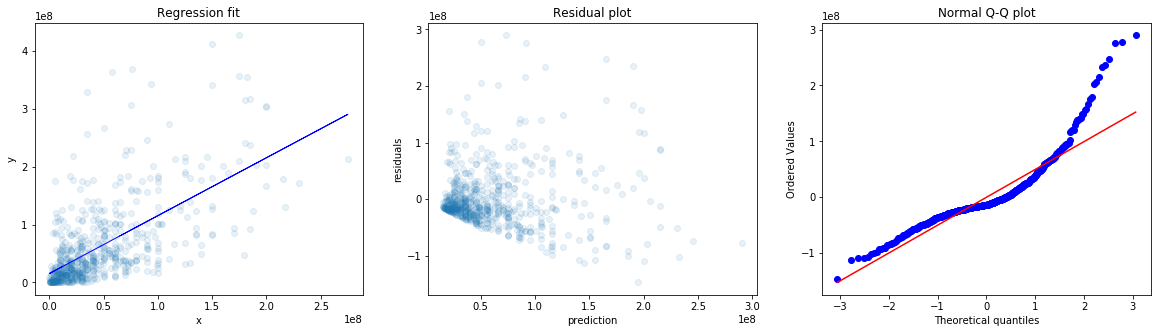

In [131]:
diagnostic_plot(X_test, y_test)

Appears to be some level of heteroskedasticity per residual plot (middle), with residuals getting larger as the prediction values get larger, giving a cone-shape spread

5-fold cross validation to validate R^2 score:

In [132]:
lm = LinearRegression()

cross_val_score(lm, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.42658254, 0.41037619, 0.32037613, 0.41031537, 0.39106338])

In [133]:
print(np.mean(cross_val_score(lm, X_train, y_train, cv=5, scoring='r2')))

0.3917427199688304


A model with just the budget feature results in R^2 of 0.391

In [134]:
#Root Mean Squared Error (RMSE)
from sklearn.metrics import mean_squared_error

def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual,predicted))   

In [135]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

## Expand model
Run it with a few features (3 or 4), so it is still humanly interpretable. Plot distribution of target variable, errors vs. predicted value to see if non-linearity or heteroskedasticity are an issue. Check fit of the model. Possibly run statsmodels to calculate p-values and see if they correspond to your intuition

Expand model to include director power, star power, star appearances and star points, for a total of five features:

In [136]:
expanded_df = movies_df[['production_budget', 'director_power', 
                         'star_power', 'star_appearances', 'star_points', 
                         'domestic_gross']] 

In [137]:
X = expanded_df.loc[:,['production_budget', 'director_power', 
                      'star_power', 'star_appearances', 'star_points']] 

y = expanded_df['domestic_gross']

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=1)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
#                                                  test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2                                                 

In [139]:
print(X_train.shape, X_test.shape)

(2505, 5) (627, 5)


In [140]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     344.9
Date:                Sun, 19 Apr 2020   Prob (F-statistic):          1.46e-281
Time:                        14:06:36   Log-Likelihood:                -48074.
No. Observations:                2505   AIC:                         9.616e+04
Df Residuals:                    2499   BIC:                         9.620e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               8.96e+06   2.03e+06      4.403      0.000    4.97e+06     1.3e+07
production_budget     0.8495      0.028     30.235      0.000       0.794       0.905
director_power        0.0881      0.022      3.932      0.000       0.044       0.132
star_power            0.2449      0.044      5.542      0.000       0.158       0.332
star_appearances  -4.189e+05   9.52e+04     -4.399      0.000   -6.06e+05   -2.32e+05
star_points        1.925e+04   6871.705      2.802      0.005    5776.700    3.27e+04
==============================================================================
Omnibus:                     1141.176   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8232.204
Skew:                           2.017   Prob(JB):                         0.00
Kurtosis:                      10.912   Cond. No.                     1.83e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.83e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

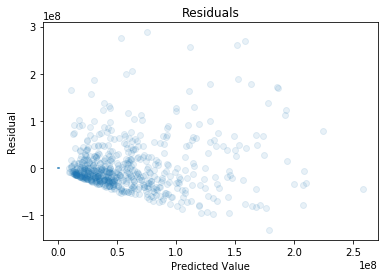

In [141]:
y_pred = results.predict(sm.add_constant(X_test))

plt.scatter(y_pred,y_test-y_pred,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,0,1000))
plt.title('Residuals')
plt.xlabel('Predicted Value')
plt.ylabel('Residual');

5-fold cross validation to validate R^2 score:

In [142]:
lm = LinearRegression()

cross_val_score(lm, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.43230205, 0.42851093, 0.34772822, 0.41667035, 0.39578062])

In [143]:
print(np.mean(cross_val_score(lm, X_train, y_train, cv=5, scoring='r2')))

0.4041984336841802


Adding in those four features increased out R^2 from 0.391 to 0.404

**Now let's add the remaining features, for a total of 9 features:**. 

In [144]:
movies_df.shape

(3132, 15)

In [145]:
complete_df = movies_df[[
    'runtime', 'year', 'genre_count', 'title_length', 'production_budget',
    'director_power', 'star_power', 'star_appearances', 'star_points',
    'domestic_gross'
]]

In [146]:
X = complete_df.loc[:, [
    'runtime', 'year', 'genre_count', 'title_length', 'production_budget',
    'director_power', 'star_power', 'star_appearances', 'star_points'
]]

y = expanded_df['domestic_gross']

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=1)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
#                                                  test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2                                                 

In [148]:
print(X_train.shape, X_test.shape)

(2505, 9) (627, 9)


In [149]:
complete_df.shape

(3132, 10)

In [150]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     195.1
Date:                Sun, 19 Apr 2020   Prob (F-statistic):          5.97e-281
Time:                        14:06:48   Log-Likelihood:                -48064.
No. Observations:                2505   AIC:                         9.615e+04
Df Residuals:                    2495   BIC:                         9.621e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.052e+09   3.31e+08      3.176      0.002    4.03e+08     1.7e+09
runtime            1.402e+04   6.22e+04      0.225      0.822   -1.08e+05    1.36e+05
year              -5.206e+05   1.65e+05     -3.154      0.002   -8.44e+05   -1.97e+05
genre_count       -2.599e+06   1.76e+06     -1.474      0.141   -6.06e+06    8.59e+05
title_length       3.676e+05   1.39e+05      2.643      0.008    9.49e+04     6.4e+05
production_budget     0.8417      0.029     28.594      0.000       0.784       0.899
director_power        0.0931      0.023      4.128      0.000       0.049       0.137
star_power            0.2251      0.044      5.079      0.000       0.138       0.312
star_appearances  -2.564e+05   1.06e+05     -2.423      0.015   -4.64e+05   -4.89e+04
star_points        1.879e+04   7019.609      2.677      0.007    5024.876    3.26e+04
==============================================================================
Omnibus:                     1142.563   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8238.528
Skew:                           2.020   Prob(JB):                         0.00
Kurtosis:                      10.913   Cond. No.                     2.99e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Runtime, genre count and title length don't appear to be statistically significant**

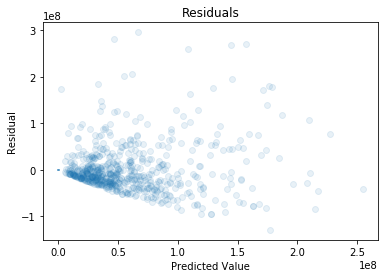

In [151]:
y_pred = results.predict(sm.add_constant(X_test))

plt.scatter(y_pred,y_test-y_pred,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,0,1000))
plt.title('Residuals')
plt.xlabel('Predicted Value')
plt.ylabel('Residual');

5-fold cross validation to validate R^2 score:

In [152]:
lm = LinearRegression()

cross_val_score(lm, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.43092875, 0.4326549 , 0.35374205, 0.425567  , 0.39481366])

In [153]:
print(np.mean(cross_val_score(lm, X_train, y_train, cv=5, scoring='r2')))

0.40754127244234645


This model evaluates to an R^2 of 0.407, a 0.003 increase from 0.404 

## Categorical Features

Incorporate categorical features in genre, certificate and month via one-hot encoding:

In [270]:
movies_matrix = pd.get_dummies(movies_genre_df, prefix=['genre'], columns=['genre'])

In [271]:
movies_matrix = pd.get_dummies(movies_matrix, prefix=['certificate', 'month'], columns=['certificate', 'month'], drop_first=True)

In [272]:
movies_matrix.head(3)

,movie,imdb,metascore,votes,runtime,year,release_date,genre_count,director,title_length,...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,10 Cloverfield Lane,7.2,76.0,276310,103,2016,2016-01-04,3,Dan Trachtenberg,19,...,0,0,1,0,0,0,0,0,0,0
1,10 Cloverfield Lane,7.2,76.0,276310,103,2016,2016-01-04,3,Dan Trachtenberg,19,...,0,0,1,0,0,0,0,0,0,0
2,10 Cloverfield Lane,7.2,76.0,276310,103,2016,2016-01-04,3,Dan Trachtenberg,19,...,0,0,1,0,0,0,0,0,0,0


In [273]:
movies_genre_df.shape

(8212, 20)

In [274]:
movies_matrix.shape

(8212, 55)

Aggregate the dataframe to one row per movie by summing the encoded genre features:

In [275]:
groupby_cols = [
    'runtime',
    'year',
    'domestic_gross',
    'production_budget',
    'genre_count',
    'director',
    'title_length',
    'director_power',
    'star_power',
    'star_points',
    'star_appearances',
    'certificate_NC-17',
    'certificate_Not Rated',  #'certificate_G' 
    'certificate_PG',
    'certificate_PG-13',
    'certificate_R',
    'month_Sep',
    'month_Jul',
    'month_Oct',  #'month_Apr'
    'month_Aug',
    'month_Dec',
    'month_Feb',
    'month_Jan',
    'month_Jun',
    'month_Mar',
    'month_May',
    'month_Nov'
]

encoded_cols = [
    'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Biography',
    'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama',
    'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror',
    'genre_Music', 'genre_Musical', 'genre_Mystery', 'genre_News',
    'genre_Romance', 'genre_Sci-Fi', 'genre_Sport', 'genre_Thriller',
    'genre_War', 'genre_Western'
]

movies_matrix = movies_matrix.groupby(
    groupby_cols, as_index=False)[encoded_cols].sum().drop_duplicates(subset=[
        'production_budget', 'domestic_gross', 'title_length', 'director',
        'year', 'runtime'
    ])

#movies_matrix.reset_index(drop=True, inplace=True)

In [276]:
movies_matrix.shape

(3133, 49)

In [277]:
movies_matrix.head()

,runtime,year,domestic_gross,production_budget,genre_count,director,title_length,director_power,star_power,star_points,...,genre_Music,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western
0,63,2011,26692846,30000000,3,Stephen J. Anderson,15,0.0,3.779329e+07,0.00,...,0,0,0,0,0,0,0,0,0,0
1,72,2003,47901582,20000000,3,Steve Trenbirth,17,0.0,1.116799e+08,254.75,...,0,0,0,0,0,0,0,0,0,0
2,75,2008,26638520,35000000,2,Craig Mazin,15,0.0,2.548471e+07,0.00,...,0,0,0,0,0,0,0,0,0,0
3,76,2004,50026353,110000000,3,Will Finn,17,0.0,4.017749e+07,0.00,...,0,0,0,0,0,0,0,0,0,0
4,76,2005,19478106,35000000,3,Gary Chapman,7,0.0,3.367443e+07,215.25,...,0,0,0,0,0,0,0,0,0,0


Save movies matrix to pickle and csv:

In [278]:
movies_matrix.to_pickle('movies_matrix.pkl')

In [279]:
movies_matrix.to_csv('movies_matrix.csv')

In [280]:
movies_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3133 entries, 0 to 3326
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   runtime                3133 non-null   int64  
 1   year                   3133 non-null   int64  
 2   domestic_gross         3133 non-null   int64  
 3   production_budget      3133 non-null   int64  
 4   genre_count            3133 non-null   int64  
 5   director               3133 non-null   object 
 6   title_length           3133 non-null   int64  
 7   director_power         3133 non-null   float64
 8   star_power             3133 non-null   float64
 9   star_points            3133 non-null   float64
 10  star_appearances       3133 non-null   int64  
 11  certificate_NC-17      3133 non-null   uint64 
 12  certificate_Not Rated  3133 non-null   uint64 
 13  certificate_PG         3133 non-null   uint64 
 14  certificate_PG-13      3133 non-null   uint64 
 15  cert

In [281]:
movies_matrix.columns

Index(['runtime', 'year', 'domestic_gross', 'production_budget', 'genre_count',
       'director', 'title_length', 'director_power', 'star_power',
       'star_points', 'star_appearances', 'certificate_NC-17',
       'certificate_Not Rated', 'certificate_PG', 'certificate_PG-13',
       'certificate_R', 'month_Sep', 'month_Jul', 'month_Oct', 'month_Aug',
       'month_Dec', 'month_Feb', 'month_Jan', 'month_Jun', 'month_Mar',
       'month_May', 'month_Nov', 'genre_Action', 'genre_Adventure',
       'genre_Animation', 'genre_Biography', 'genre_Comedy', 'genre_Crime',
       'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy',
       'genre_History', 'genre_Horror', 'genre_Music', 'genre_Musical',
       'genre_Mystery', 'genre_News', 'genre_Romance', 'genre_Sci-Fi',
       'genre_Sport', 'genre_Thriller', 'genre_War', 'genre_Western'],
      dtype='object')

In [282]:
all_df = movies_matrix[[
    'runtime',
    'year',
    'genre_count',
    'title_length',
    'production_budget',
    'domestic_gross',  #director
    'director_power',
    'star_power',
    'star_points',
    'star_appearances',
    'certificate_NC-17',
    'certificate_Not Rated',  #'certificate_G' 
    'certificate_PG',
    'certificate_PG-13',
    'certificate_R',
    'month_Sep',
    'month_Jul',
    'month_Oct',  #'month_Apr'
    'month_Aug',
    'month_Dec',
    'month_Feb',
    'month_Jan',
    'month_Jun',
    'month_Mar',
    'month_May',
    'month_Nov',
    'genre_Action',
    'genre_Adventure',
    'genre_Animation',
    'genre_Biography',
    'genre_Comedy',
    'genre_Crime',
    'genre_Documentary',
    'genre_Drama',
    'genre_Family',
    'genre_Fantasy',
    'genre_History',
    'genre_Horror',
    'genre_Music',
    'genre_Musical',
    'genre_Mystery',
    'genre_News',
    'genre_Romance',
    'genre_Sci-Fi',
    'genre_Sport',
    'genre_Thriller',
    'genre_War',
    'genre_Western'
]]

In [283]:
X = all_df.loc[:, [
    'runtime',
    'year',
    'genre_count',
    'title_length',  #director
    'production_budget',
    'director_power',
    'star_power',
    'star_points',
    'star_appearances',
    'certificate_NC-17',
    'certificate_Not Rated',  #'certificate_G' 
    'certificate_PG',
    'certificate_PG-13',
    'certificate_R',
    'month_Sep',
    'month_Jul',
    'month_Oct',  #'month_Apr'
    'month_Aug',
    'month_Dec',
    'month_Feb',
    'month_Jan',
    'month_Jun',
    'month_Mar',
    'month_May',
    'month_Nov',
    'genre_Action',
    'genre_Adventure',
    'genre_Animation',
    'genre_Biography',
    'genre_Comedy',
    'genre_Crime',
    'genre_Documentary',
    'genre_Drama',
    'genre_Family',
    'genre_Fantasy',
    'genre_History',
    'genre_Horror',
    'genre_Music',
    'genre_Musical',
    'genre_Mystery',
    'genre_News',
    'genre_Romance',
    'genre_Sci-Fi',
    'genre_Sport',
    'genre_Thriller',
    'genre_War',
    'genre_Western'
]]

y = all_df['domestic_gross']

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=1)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
#                                                  test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2                                                 

In [285]:
print(X_train.shape, X_test.shape)

(2506, 47) (627, 47)


In [170]:
model = sm.OLS(y_train, sm.add_constant(X_train)) #, X.astype(float))
results = model.fit()

results.summary()

#est = sm.OLS(y, X.astype(float)).fit()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     46.17
Date:                Sun, 19 Apr 2020   Prob (F-statistic):          5.49e-298
Time:                        14:08:51   Log-Likelihood:                -47998.
No. Observations:                2506   AIC:                         9.609e+04
Df Residuals:                    2458   BIC:                         9.637e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6.674e+08   3.37e+08      1.983      0.047    7.57e+06    1.33e+09
runtime                5.425e+05   7.57e+04      7.163      0.000    3.94e+05    6.91e+05
year                  -3.321e+05   1.68e+05     -1.979      0.048   -6.61e+05   -2954.718
genre_count           -5.109e+06   3.31e+06     -1.545      0.122   -1.16e+07    1.38e+06
title_length           1.637e+05    1.4e+05      1.165      0.244   -1.12e+05    4.39e+05
production_budget         0.6773      0.038     17.837      0.000       0.603       0.752
director_power            0.0525      0.022      2.431      0.015       0.010       0.095
star_power                0.1567      0.044      3.558      0.000       0.070       0.243
star_points            3.296e+04   7033.151      4.686      0.000    1.92e+04    4.68e+04
star_appearances      -1.997e+05   1.09e+05     -1.830      0.067   -4.14e+05    1.43e+04
certificate_NC-17     -6.011e+07   3.11e+07     -1.930      0.054   -1.21e+08    9.53e+05
certificate_Not Rated -5.973e+07   1.39e+07     -4.306      0.000   -8.69e+07   -3.25e+07
certificate_PG          -3.4e+07   8.82e+06     -3.856      0.000   -5.13e+07   -1.67e+07
certificate_PG-13     -3.798e+07   9.71e+06     -3.912      0.000    -5.7e+07   -1.89e+07
certificate_R         -4.949e+07   9.81e+06     -5.044      0.000   -6.87e+07   -3.02e+07
month_Sep             -6.977e+06    5.2e+06     -1.341      0.180   -1.72e+07    3.22e+06
month_Jul              1.066e+07   5.32e+06      2.004      0.045    2.27e+05    2.11e+07
month_Oct             -3.989e+06   5.02e+06     -0.795      0.426   -1.38e+07    5.85e+06
month_Aug              5.539e+05   5.18e+06      0.107      0.915    -9.6e+06    1.07e+07
month_Dec              6.466e+05   5.06e+06      0.128      0.898   -9.28e+06    1.06e+07
month_Feb              5.221e+06    5.7e+06      0.915      0.360   -5.96e+06    1.64e+07
month_Jan              4.345e+06   6.32e+06      0.687      0.492   -8.05e+06    1.67e+07
month_Jun              1.896e+07   5.46e+06      3.470      0.001    8.25e+06    2.97e+07
month_Mar              2.119e+06   5.48e+06      0.386      0.699   -8.64e+06    1.29e+07
month_May              1.829e+07   5.75e+06      3.181      0.001    7.01e+06    2.96e+07
month_Nov              4.309e+06   5.18e+06      0.832      0.406   -5.85e+06    1.45e+07
genre_Action          -6.418e+06   3.83e+06     -1.676      0.094   -1.39e+07    1.09e+06
genre_Adventure        1.077e+07   4.31e+06      2.498      0.013    2.32e+06    1.92e+07
genre_Animation        2.111e+07   6.65e+06      3.176      0.002    8.08e+06    3.41e+07
genre_Biography       -7.222e+05   5.01e+06     -0.144      0.885   -1.06e+07    9.11e+06
genre_Comedy           9.727e+06   3.56e+06      2.734      0.006    2.75e+06    1.67e+07
genre_Crime            

5-fold cross validation to validate R^2 score:

In [171]:
lm = LinearRegression()

cross_val_score(lm, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.40562239, 0.42645019, 0.45709445, 0.43295814, 0.47556212])

In [172]:
print(np.mean(cross_val_score(lm, X_train, y_train, cv=5, scoring='r2')))

0.43953745973231956


R^2 increased from 0.407 to 0.439

## Challenge model
Considering the bias vs. variance tradeoff, let's add complexity by adding non-linearity through polynomial features:

In [52]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [53]:
X_train.shape

(2506, 47)

In [173]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm.score(X_train, y_train)

0.4688887359002935

In [181]:
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(X_train)
lm.fit(x_train_poly, y_train)
x_test_poly = poly.transform(X_test)
lm.score(x_train_poly, y_train) #score result on train dataset

0.5507477468115718

In [185]:
lm.score(x_test_poly, y_test) #score result on test dataset

0.48687978216386524

In [183]:
cross_val_score(lm, x_train_poly, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.27611844, 0.3430116 , 0.37209791, 0.38756618, 0.37123944])

In [184]:
print(np.mean(cross_val_score(lm, x_train_poly, y_train, cv=5, scoring='r2'))) #score results across test sets

0.35000671423613267


In [59]:
p.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16',
 'x17',
 'x18',
 'x19',
 'x20',
 'x21',
 'x22',
 'x23',
 'x24',
 'x25',
 'x26',
 'x27',
 'x28',
 'x29',
 'x30',
 'x31',
 'x32',
 'x33',
 'x34',
 'x35',
 'x36',
 'x37',
 'x38',
 'x39',
 'x40',
 'x41',
 'x42',
 'x43',
 'x44',
 'x45',
 'x46',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x0 x8',
 'x0 x9',
 'x0 x10',
 'x0 x11',
 'x0 x12',
 'x0 x13',
 'x0 x14',
 'x0 x15',
 'x0 x16',
 'x0 x17',
 'x0 x18',
 'x0 x19',
 'x0 x20',
 'x0 x21',
 'x0 x22',
 'x0 x23',
 'x0 x24',
 'x0 x25',
 'x0 x26',
 'x0 x27',
 'x0 x28',
 'x0 x29',
 'x0 x30',
 'x0 x31',
 'x0 x32',
 'x0 x33',
 'x0 x34',
 'x0 x35',
 'x0 x36',
 'x0 x37',
 'x0 x38',
 'x0 x39',
 'x0 x40',
 'x0 x41',
 'x0 x42',
 'x0 x43',
 'x0 x44',
 'x0 x45',
 'x0 x46',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x1 x6',
 'x1 x7',
 'x1 x8',
 'x1 x9',
 'x1 x10',
 'x1 x11',
 'x1 x12',


In [186]:
m.coef_

array([-8.21786448e-01, -2.82506540e+03, -1.96824950e+03, ...,
        6.91621035e+00,  0.00000000e+00, -4.65848109e+00])

In [187]:
x_train_poly.shape

(2506, 1176)

## Refine model
Add or remove complexity (using a more sophisticated model or making your model more conservative by using regularization). Compare with unrefined model (error vs. y_pred, R^2, MAE, RMSE). Use regularization to fine tune model (Ridge, Lasso; Lasso may eliminate coefficients that you included at first

**Fit the Standard Scaler to the training data:**

In [192]:
x_train_poly = p.fit_transform(X_train)
std = StandardScaler()
x_train_poly_scale = std.fit_transform(x_train_poly)
x_test_poly_scale = std.transform(x_test_poly) #added
lm.fit(x_train_poly_scale, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [193]:
type(X_train), type(x_train_poly_scale)

(pandas.core.frame.DataFrame, numpy.ndarray)

(array([ 178.,    0.,    0.,    0.,  599.,    0.,    0.,    0.,    0.,
        1729.]),
 array([-2.63344915, -2.308114  , -1.98277884, -1.65744369, -1.33210854,
        -1.00677339, -0.68143823, -0.35610308, -0.03076793,  0.29456722,
         0.61990238]),
 <a list of 10 Patch objects>)

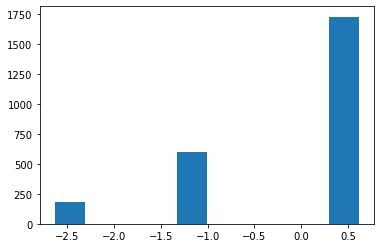

In [190]:
plt.hist(x_train_poly_scale[:,3])

In [194]:
x_train_poly_scale.shape

(2506, 1176)

In [195]:
x_train_poly_scale

array([[ 0.        ,  0.01667504,  1.48598488, ..., -0.11551674,
         0.        , -0.07495317],
       [ 0.        , -0.31236151, -0.96824059, ..., -0.11551674,
         0.        , -0.07495317],
       [ 0.        , -0.64139806, -0.96824059, ..., -0.11551674,
         0.        , -0.07495317],
       ...,
       [ 0.        , -0.53171921,  0.80425558, ..., -0.11551674,
         0.        , -0.07495317],
       [ 0.        , -1.18979231, -0.01381957, ..., -0.11551674,
         0.        , -0.07495317],
       [ 0.        , -0.53171921, -0.28651129, ..., -0.11551674,
         0.        , -0.07495317]])

In [196]:
## Fit a LASSO model on the standardized data

lasso_model = Lasso(alpha = 100)
lasso_model.fit(x_train_poly_scale, y_train)

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0226397445745354e+18, tolerance: 1195589538844501.8
  positive)


Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [200]:
## Note that now we can meaningful compare the importance of
## different features, since they're on the same scale

## But it's now difficult to interpret the coefficients
## We would need to translate back to the original feature scales by dividing
## each coefficient by the original column's standard deviation

lasso_coef_list = list(zip(p.get_feature_names(input_features=X_train.columns), lasso_model.coef_)) #X_train.columns
lasso_coef_list.sort(key=lambda x:x[1])

In [201]:
lasso_coef_list

[('genre_count production_budget', -47116262.96754066),
 ('month_Dec^2', -46557207.10680513),
 ('runtime certificate_PG', -43643491.809995115),
 ('runtime genre_count', -42378485.73074374),
 ('year title_length', -40212583.03367699),
 ('director_power', -35797931.67047438),
 ('star_power certificate_PG-13', -29610509.063580617),
 ('runtime production_budget', -27696996.753363505),
 ('year genre_Romance', -26365226.98193839),
 ('year genre_Action', -25450388.39589942),
 ('star_power certificate_R', -25437820.455997597),
 ('genre_count month_Jul', -25105848.93852629),
 ('year genre_Sci-Fi', -24688780.301592756),
 ('genre_count genre_Music', -24444955.280307632),
 ('month_Oct^2', -24141627.95701811),
 ('runtime genre_Drama', -23809812.72505948),
 ('genre_Adventure^2', -23261405.21642248),
 ('year genre_Animation', -21615102.73039755),
 ('month_May', -19845677.403855372),
 ('certificate_R genre_Action', -19264244.692492574),
 ('certificate_R month_Nov', -18445273.09945943),
 ('star_power c

In [202]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(x_test_poly_scale)

In [204]:
# Find the MAE and R^2 on the test set using this model
print(mae(y_test, test_set_pred), r2_score(y_test, test_set_pred))

42870240.82496922 0.21584775202840223


Automated Regularization Strength Tuning via Cross-validation:

In [205]:
## Scale the data as before
# std = StandardScaler()
# std.fit(X_train.values)

x_train_poly = poly.fit_transform(X_train)
std = StandardScaler()
x_train_poly_scale = std.fit_transform(x_train_poly)
#m.fit(x_train_poly_scale, y_train)

In [206]:
## Scale the Predictors on both the train and test set
#X_tr = std.transform(X_train.values)
#X_te = std.transform(X_test.values)
x_test_poly_scale = std.transform(x_test_poly)

In [207]:
print(len(x_train_poly_scale), len(x_test_poly_scale))

2506 627


In [208]:
x_test_poly_scale

array([[ 0.        ,  0.72958756,  1.0769473 , ..., -0.11551674,
         0.        , -0.07495317],
       [ 0.        , -1.35431059, -2.05900747, ..., -0.11551674,
         0.        , -0.07495317],
       [ 0.        ,  0.12635389,  0.12252629, ..., -0.11551674,
         0.        , -0.07495317],
       ...,
       [ 0.        ,  1.33282123,  1.34963902, ...,  8.65675424,
         0.        , -0.07495317],
       [ 0.        , -0.25752209,  0.53156387, ..., -0.11551674,
         0.        , -0.07495317],
       [ 0.        ,  0.34571159,  0.12252629, ..., -0.11551674,
         0.        , -0.07495317]])

In [209]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(x_train_poly_scale, y_train)

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.556489831930692e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5399367946757652e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.52900960320491e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5292035189300849e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5295913563065523e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.529962569961572e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5331269541765798e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5330914196084042e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5330489396000668e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinat

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5303819738122813e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5302387598329772e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5300941952909955e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinat

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5262986458867543e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5261468303276252e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5259954007615826e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinat

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5223937276045783e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5222585195556234e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5221240580899205e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinat

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5190080580005363e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5188931328955814e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5187789344711706e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinat

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5161496079605435e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.516052992968027e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.515956996669433e+18, tolerance: 1018333818158651.5
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4236699588750267e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4241551523193603e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4246126340465462e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4281812932633976e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4281243016543788e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.428057550385634e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.424482176608668e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4243055559459407e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4241276986001441e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4193668036788716e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4191865087915904e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4190068207299256e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4146102779946988e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.41445319151608e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4142970472851658e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_des

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4105659835642253e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4104348150260838e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4103045252337418e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.407209275597974e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4071008182259464e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4069930962566216e+18, tolerance: 981372509662119.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.343833770966494e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.344405885245469e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3449730535123832e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_des

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3506534410818232e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3506697509107325e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.350677089613121e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3488550651766077e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3487390589864458e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3486213070555162e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3452586464515223e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.345126320595553e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.344994216262186e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_des

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3417110275355973e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3415924471598746e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.34147451981055e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_des

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3386436253492708e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.338543774684016e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3384445771929024e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.33608457492605e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.336001787946673e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3359195481285962e+18, tolerance: 916486915943969.2
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desc

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2727165913375785e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2732937204660928e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.274054293894078e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2914328661202148e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.291718208234959e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2919840373105536e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2943865550016164e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2943695000183872e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.294347697386047e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.292742724203387e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2926584384763873e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.292573389480608e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_des

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2902587701974154e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2901701964511985e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2900818771896612e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.287909665478725e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2878317121459814e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.287754205352774e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_des

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2858960173305454e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2858304719681812e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.28576535037669e+18, tolerance: 892081528548945.4
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_des

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.44135187569937e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4418641228887217e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4428589850231596e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_des

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4608051852103583e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4609693075844234e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4611133160341806e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4607412512974226e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4606276657768596e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.460509715809295e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4565962155632248e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4564295639105766e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4562625758286938e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4519670461797025e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4518073812014886e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4516483259760246e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4477587435746668e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4476192771235256e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4474805813022953e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4441404243858132e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4440218849298941e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4439040521032576e+18, tolerance: 972365428929578.6
  tol, rng, random, positive)
/Users/johnlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [210]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

91.15888299750827

In [211]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
lasso_coef_listf = list(zip(poly.get_feature_names(input_features=X_train.columns), lasso_model.coef_))
lasso_coef_listf.sort(key=lambda x:x[1])

In [212]:
lasso_coef_listf

[('genre_count production_budget', -47124016.30580792),
 ('month_Dec^2', -46570298.02136835),
 ('runtime certificate_PG', -43653181.285362564),
 ('runtime genre_count', -42390851.94205219),
 ('year title_length', -40232868.51806687),
 ('director_power', -35805471.615625),
 ('star_power certificate_PG-13', -29621348.022686623),
 ('runtime production_budget', -27702912.94148398),
 ('year genre_Romance', -26370891.403272897),
 ('year genre_Action', -25458132.70168583),
 ('star_power certificate_R', -25447099.842037495),
 ('genre_count month_Jul', -25106578.549458142),
 ('year genre_Sci-Fi', -24679429.001198974),
 ('genre_count genre_Music', -24446110.15079283),
 ('month_Oct^2', -24147584.08838177),
 ('runtime genre_Drama', -23807771.919168048),
 ('genre_Adventure^2', -23276341.452324927),
 ('year genre_Animation', -21626580.349117186),
 ('month_May', -19865047.0982698),
 ('certificate_R genre_Action', -19272693.00262388),
 ('certificate_R month_Nov', -18442372.786299434),
 ('star_power ce

In [213]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(x_test_poly_scale)

In [214]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)
r2_score(y_test, test_set_pred)

0.21550308672472107

**Apply RidgeCV:**

In [227]:
alphas=[1e-3, 1e-2, 1e-1, 1, 10]

for alpha in alphas:
    ridge_model = RidgeCV(alphas=[alpha]).fit(x_train_poly_scale, y_train)
    print(ridge_model.score(x_train_poly_scale, y_train), ridge_model.score(x_test_poly_scale, y_test))

0.6717100958897266 -0.15245205368468584
0.6682042687740527 0.05111159013508759
0.6627279870514795 0.1827287657209694
0.6593268507997643 0.2791834736131906
0.649453481447861 0.37145316223203595


In [226]:
ridge_model.alpha_

10

In [228]:
test_set_pred = ridge_model.predict(x_test_poly_scale)

In [232]:
mae(y_test, test_set_pred)

38727023.93603356

In [229]:
r2_score(y_test, test_set_pred)

0.37145316223203595

**Random Forest Tree:**

In [79]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                    test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2                                                 

In [80]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(n_estimators=1800, max_features=3)
rf.fit(X_train, y_train)
rf.score(X_val, y_val)

0.45804963259168857

In [81]:
r2_score(y_val, rf.predict(X_val))

0.4580496325916885

In [82]:
RMSE(rf.predict(X_val), y_val)

52115109.709071584

In [83]:
mae(rf.predict(X_val), y_val)

35090731.24512228

**Gradient Boosting Regressor:**

In [84]:
gbm = GradientBoostingRegressor(n_estimators=1600, max_depth=3, learning_rate=.01)
gbm.fit(X_train, y_train)
gbm.score(X_val, y_val)

0.4562717659180845

In [85]:
r2_score(y_val, gbm.predict(X_val))

0.4562717659180845

In [86]:
RMSE(gbm.predict(X_val),y_val)

52200521.45443508

In [87]:
mae(gbm.predict(X_val), y_val)

34417591.085740395

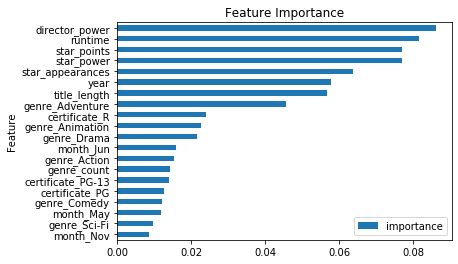

In [88]:
feat_imps = list(zip(X_train.columns, rf.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])
feat_imps[26:46].plot(x='feature',y='importance',kind='barh') 

plt.title('Feature Importance')
#plt.xlabel('Predicted Value')
plt.ylabel('Feature') 
#sns.figure(figsize(10,5))  
#sns.set_context(context=None,font_scale=1)
plt.savefig("feature_importance.png") ;

Choosing Random Forest Tree as the final model due to the higher R^2 and lower RMSE relative to GBM

## Test model
How does your final, refined model perform on out-of-sample data? If it does well, hurray! If not, linear regression (with this data set) may not be the answer and you have to move to find more features, more data, or more complex models that are harder to interpret.

Combine back the X_train and X_val, and Y_train and Y_val, into the original 80% training set, to re-train the random forest tree model:

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                    test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2                                                 

In [870]:
X_train_final = pd.concat([X_train, X_val], ignore_index=True)
y_train_final = pd.concat([y_train, y_val], ignore_index=True)

In [876]:
rf = RandomForestRegressor(n_estimators=1800, max_features=3)
rf.fit(X_train_final, y_train_final)
rf.score(X_test, y_test)

0.4987188332968963

In [877]:
r2_score(y_test, rf.predict(X_test))

0.49871883329689626

In [878]:
RMSE(rf.predict(X_test), y_test)

47637781.11325671

In [879]:
mae(rf.predict(X_test), y_test)

33338138.149470992

Let's see the results look between actual and predicted:

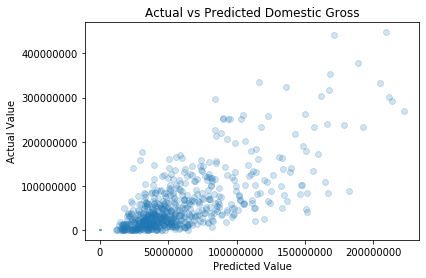

In [90]:
y_pred = rf.predict(X_test)

plt.scatter(y_pred, y_test, alpha=.2)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,0,1000))
plt.title('Actual vs Predicted Domestic Gross')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value') ;

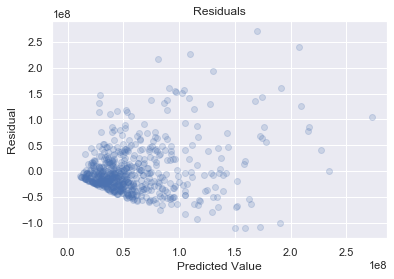

In [885]:
y_pred = rf.predict(X_test)

plt.scatter(y_pred, y_test-y_pred, alpha=.2)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,0,1000))
plt.title('Residuals')
plt.xlabel('Predicted Value')
plt.ylabel('Residual');

In [91]:
y_test-y_pred

2503   -5.458360e+07
110    -3.437970e+07
1933   -5.176689e+06
1605   -2.001185e+07
1483   -1.621133e+07
            ...     
3004   -2.971585e+07
1380    7.788473e+07
2841   -2.956153e+07
1463    2.602722e+07
2156    1.086982e+08
Name: domestic_gross, Length: 627, dtype: float64

**Error Analysis:**

In [253]:
y_test.head()

2503    10161183
110     27281507
1933    70231041
1605     7800825
1483     1305195
Name: domestic_gross, dtype: int64

In [254]:
X_test.head()

,runtime,year,genre_count,title_length,production_budget,director_power,star_power,star_points,star_appearances,certificate_NC-17,...,genre_Music,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western
2503,123,2015,3,8,35000000,1.401304e+08,3.160915e+07,141.25,11,0,...,0,0,0,0,0,0,0,0,0,0
110,85,1992,3,26,12000000,0.000000e+00,0.000000e+00,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0
1933,112,2008,3,11,72500000,9.248674e+07,3.994108e+07,223.25,27,0,...,0,0,0,0,0,0,0,0,0,0
1605,107,2008,3,9,15000000,0.000000e+00,6.034129e+07,235.00,15,0,...,0,0,0,0,0,0,0,0,0,0
1483,105,2016,3,16,6400000,0.000000e+00,2.157191e+07,227.50,13,0,...,0,0,1,0,0,0,0,1,0,0


Merge y_test with X_test:

In [351]:
merge_test = X_test.merge(y_test.rename('y_test'), left_index=True, right_index=True)

In [352]:
merge_test.head()

,runtime,year,genre_count,title_length,production_budget,director_power,star_power,star_points,star_appearances,certificate_NC-17,...,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western,y_test
2649,123,2015,3,8,35000000,1.401304e+08,3.160915e+07,141.25,11,0,...,0,0,0,0,0,0,0,0,0,10161183
112,85,1992,3,26,12000000,0.000000e+00,0.000000e+00,0.00,0,0,...,0,0,0,0,0,0,0,0,0,27281507
2034,112,2008,3,11,72500000,9.248674e+07,3.994108e+07,223.25,27,0,...,0,0,0,0,0,0,0,0,0,70231041
1686,107,2008,3,9,15000000,0.000000e+00,6.034129e+07,235.00,15,0,...,0,0,0,0,0,0,0,0,0,7800825
1555,105,2016,3,16,6400000,0.000000e+00,2.157191e+07,227.50,13,0,...,0,1,0,0,0,0,1,0,0,1305195


Now merge with y_pred:

In [353]:
merge_test = merge_test.merge(y_pred.rename('y_pred'), left_index=True, right_index=True) #merge_test = merge_test.merge(s.rename('new'), left_index=True, right_index=True) 

In [354]:
merge_test.columns

Index(['runtime', 'year', 'genre_count', 'title_length', 'production_budget',
       'director_power', 'star_power', 'star_points', 'star_appearances',
       'certificate_NC-17', 'certificate_Not Rated', 'certificate_PG',
       'certificate_PG-13', 'certificate_R', 'month_Sep', 'month_Jul',
       'month_Oct', 'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan',
       'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'genre_Action',
       'genre_Adventure', 'genre_Animation', 'genre_Biography', 'genre_Comedy',
       'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family',
       'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music',
       'genre_Musical', 'genre_Mystery', 'genre_News', 'genre_Romance',
       'genre_Sci-Fi', 'genre_Sport', 'genre_Thriller', 'genre_War',
       'genre_Western', 'y_test', 'y_pred'],
      dtype='object')

In [355]:
merge_test.y_test = merge_test.y_test.astype('float64')

In [356]:
merge_test.y_test.unique()

array([2.41461610e+07, 2.33415680e+07, 1.15802596e+08, 3.94428710e+07,
       8.92965730e+07, 2.50863268e+08, 3.03311650e+07, 3.68334730e+07,
       4.76021940e+07, 5.20752700e+07, 2.87142310e+07, 4.55424210e+07,
       1.21349350e+07, 5.00263530e+07, 7.90919690e+07, 1.24317920e+07,
       7.80465700e+07, 1.06725660e+07, 5.50526700e+06, 6.13562210e+07,
       3.27469410e+07, 1.94781060e+07, 6.34086140e+07, 1.08085305e+08,
       5.82691510e+07, 1.01028233e+08, 6.31183860e+07, 7.15656690e+07,
       7.97271490e+07, 3.34464700e+07, 6.44731150e+07, 2.40073240e+07,
       8.22264740e+07, 3.05425760e+07, 3.77882280e+07, 1.01018283e+08,
       2.02523800e+06, 4.19549970e+07, 1.56340900e+07, 3.75625680e+07,
       1.18450002e+08, 1.27957460e+07, 9.41254260e+07, 3.54187230e+07,
       1.82618434e+08, 5.26985350e+07, 1.00814328e+08, 4.77700700e+06,
       2.65942610e+07, 1.76549120e+07, 2.61441092e+08, 1.05471170e+07,
       5.95648000e+06, 6.95840000e+05, 4.41377120e+07, 1.27968240e+07,
      

In [357]:
merge_test['y_residual'] = merge_test.y_test - merge_test.y_pred

In [358]:
all_df.iloc[1483]

runtime                  1.050000e+02
year                     2.016000e+03
genre_count              3.000000e+00
title_length             1.600000e+01
production_budget        6.400000e+06
domestic_gross           1.305195e+06
director_power           0.000000e+00
star_power               2.157191e+07
star_points              2.275000e+02
star_appearances         1.300000e+01
certificate_NC-17        0.000000e+00
certificate_Not Rated    0.000000e+00
certificate_PG           0.000000e+00
certificate_PG-13        0.000000e+00
certificate_R            1.000000e+00
month_Sep                0.000000e+00
month_Jul                0.000000e+00
month_Oct                0.000000e+00
month_Aug                0.000000e+00
month_Dec                0.000000e+00
month_Feb                0.000000e+00
month_Jan                0.000000e+00
month_Jun                0.000000e+00
month_Mar                0.000000e+00
month_May                0.000000e+00
month_Nov                1.000000e+00
genre_Action

In [359]:
movies_matrix.iloc[1483]

runtime                              105
year                                2016
domestic_gross                   1305195
production_budget                6400000
genre_count                            3
director                 Olivier Assayas
title_length                          16
director_power                         0
star_power                   2.15719e+07
star_points                        227.5
star_appearances                      13
certificate_NC-17                      0
certificate_Not Rated                  0
certificate_PG                         0
certificate_PG-13                      0
certificate_R                          1
month_Sep                              0
month_Jul                              0
month_Oct                              0
month_Aug                              0
month_Dec                              0
month_Feb                              0
month_Jan                              0
month_Jun                              0
month_Mar       

In [360]:
movies_genre_df.iloc[1483]

movie                       Crimson Peak
imdb                                 6.5
metascore                             66
votes                             124210
runtime                              119
certificate                            R
year                                2015
month                                Oct
release_date         2015-10-14 00:00:00
genre                              Drama
genre_count                            3
director              Guillermo del Toro
title_length                          12
production_budget               55000000
director_power               7.91378e+07
star_power                   9.66299e+07
star_appearances                      17
star_points                        607.5
worldwide_gross                 74966854
domestic_gross                  31090320
Name: 1501, dtype: object

In [361]:
merge_test

,runtime,year,genre_count,title_length,production_budget,director_power,star_power,star_points,star_appearances,certificate_NC-17,...,genre_News,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western,y_test,y_pred,y_residual
790,96,2006,2,21,1000000,5108820.0,2.977863e+07,0.00,1,0,...,1,0,0,0,0,0,0,24146161.0,6.994231e+07,-4.579615e+07
1569,106,1995,3,18,6000000,0.0,1.695589e+07,77.00,1,0,...,0,0,0,0,1,0,0,23341568.0,4.981206e+07,-2.647049e+07
1917,110,2007,3,11,120000000,51969456.2,6.460653e+07,298.00,23,0,...,0,0,0,0,1,0,0,115802596.0,3.349159e+07,8.231100e+07
335,90,2000,2,12,80000000,0.0,7.404536e+07,309.25,13,0,...,0,0,0,0,0,0,0,39442871.0,4.354723e+07,-4.104361e+06
13,78,2000,3,24,100000000,0.0,1.602980e+07,0.00,5,0,...,0,0,0,0,0,0,0,89296573.0,1.025461e+08,-1.324955e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,87,2000,3,19,15000000,0.0,1.760831e+07,40.75,1,0,...,0,0,0,0,0,0,0,12801190.0,4.238109e+07,-2.957990e+07
1638,106,2015,3,10,20000000,96522687.0,6.587071e+07,241.25,27,0,...,0,0,0,0,0,0,0,55039.0,5.716019e+07,-5.710515e+07
2176,114,2014,3,27,28000000,0.0,2.018580e+07,288.50,17,0,...,0,0,0,0,0,0,0,26017685.0,3.525874e+07,-9.241052e+06
296,89,2005,3,9,20000000,14967182.0,2.549692e+06,235.25,1,0,...,0,0,0,0,0,0,0,46752382.0,9.874713e+06,3.687767e+07


In [362]:
# merge_test = pd.merge([merge_test, all_df[]], axis=1)


In [363]:
merge_test = pd.merge(merge_test,
                      movies_matrix[[
                          'runtime', 'year', 'title_length',
                          'production_budget', 'director_power', 'director'
                      ]],
                      how='left',
                      left_on=[
                          'runtime', 'year', 'title_length',
                          'production_budget', 'director_power'
                      ],
                      right_on=[
                          'runtime', 'year', 'title_length',
                          'production_budget', 'director_power'
                      ])

In [364]:
merge_test = pd.merge(merge_test,
                      movies_df[[
                          'runtime', 'year', 'title_length',
                          'production_budget', 'director_power', 'director',
                          'movie'
                      ]],
                      how='left',
                      left_on=[
                          'runtime', 'year', 'title_length',
                          'production_budget', 'director_power', 'director',
                      ],
                      right_on=[
                          'runtime', 'year', 'title_length',
                          'production_budget', 'director_power', 'director',
                      ])

In [365]:
merge_test[merge_test.director == 'Christopher Nolan']

,runtime,year,genre_count,title_length,production_budget,director_power,star_power,star_points,star_appearances,certificate_NC-17,...,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western,y_test,y_pred,y_residual,director,movie
77,130,2006,3,12,40000000,123098882.0,5.785907e+07,606.5,35,0,...,1,0,0,0,0,53089891.0,6.017694e+07,-7.087053e+06,Christopher Nolan,The Prestige


In [366]:
movies_genre_df[movies_genre_df.director == 'Christopher Nolan']

,movie,imdb,metascore,votes,runtime,certificate,year,month,release_date,genre,genre_count,director,title_length,production_budget,director_power,star_power,star_appearances,star_points,worldwide_gross,domestic_gross
740,Batman Begins,8.2,70.0,1251924,140,PG-13,2005,Jun,2005-06-15,Action,2,Christopher Nolan,13,150000000,6.726318e+07,5.611610e+07,22,362.25,360651380,206852432
741,Batman Begins,8.2,70.0,1251924,140,PG-13,2005,Jun,2005-06-15,Adventure,2,Christopher Nolan,13,150000000,6.726318e+07,5.611610e+07,22,362.25,360651380,206852432
1877,Dunkirk,7.9,94.0,509863,106,PG-13,2017,Jul,2017-07-18,Action,3,Christopher Nolan,7,150000000,2.483435e+08,3.920468e+07,12,240.50,527268280,190068280
1878,Dunkirk,7.9,94.0,509863,106,PG-13,2017,Jul,2017-07-18,Drama,3,Christopher Nolan,7,150000000,2.483435e+08,3.920468e+07,12,240.50,527268280,190068280
1879,Dunkirk,7.9,94.0,509863,106,PG-13,2017,Jul,2017-07-18,History,3,Christopher Nolan,7,150000000,2.483435e+08,3.920468e+07,12,240.50,527268280,190068280
3022,Inception,8.8,74.0,1943744,148,PG-13,2010,Jul,2010-07-16,Action,3,Christopher Nolan,9,160000000,2.164060e+08,7.545960e+07,23,454.50,833844082,292576195
3023,Inception,8.8,74.0,1943744,148,PG-13,2010,Jul,2010-07-16,Adventure,3,Christopher Nolan,9,160000000,2.164060e+08,7.545960e+07,23,454.50,833844082,292576195
3024,Inception,8.8,74.0,1943744,148,PG-13,2010,Jul,2010-07-16,Sci-Fi,3,Christopher Nolan,9,160000000,2.164060e+08,7.545960e+07,23,454.50,833844082,292576195
3066,Insomnia,7.2,78.0,262794,118,R,2002,May,2002-05-24,Drama,3,Christopher Nolan,8,46000000,0.000000e+00,4.071387e+07,22,494.75,113622499,67263182
3067,Insomnia,7.2,78.0,262794,118,R,2002,May,2002-05-24,Mystery,3,Christopher Nolan,8,46000000,0.000000e+00,4.071387e+07,22,494.75,113622499,67263182


In [367]:
merge_test.columns

Index(['runtime', 'year', 'genre_count', 'title_length', 'production_budget',
       'director_power', 'star_power', 'star_points', 'star_appearances',
       'certificate_NC-17', 'certificate_Not Rated', 'certificate_PG',
       'certificate_PG-13', 'certificate_R', 'month_Sep', 'month_Jul',
       'month_Oct', 'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan',
       'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'genre_Action',
       'genre_Adventure', 'genre_Animation', 'genre_Biography', 'genre_Comedy',
       'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family',
       'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music',
       'genre_Musical', 'genre_Mystery', 'genre_News', 'genre_Romance',
       'genre_Sci-Fi', 'genre_Sport', 'genre_Thriller', 'genre_War',
       'genre_Western', 'y_test', 'y_pred', 'y_residual', 'director', 'movie'],
      dtype='object')

In [370]:
merge_test['absolute_residual'] = merge_test.y_residual.abs()

In [380]:
merge_test[merge_test.year.isin([2018, 2019])].sort_values(by='absolute_residual', ascending=False)

,runtime,year,genre_count,title_length,production_budget,director_power,star_power,star_points,star_appearances,certificate_NC-17,...,genre_Sport,genre_Thriller,genre_War,genre_Western,y_test,y_pred,y_residual,director,movie,absolute_residual
59,89,2018,3,28,30000000,0.000000e+00,3.267810e+07,266.50,18,0,...,0,0,0,0,4412170.0,1.548283e+08,-1.504162e+08,David Kerr,Johnny English Strikes Again,1.504162e+08
56,106,2018,2,9,10000000,3.452812e+07,7.094684e+07,100.50,12,0,...,0,1,0,0,159347015.0,1.213403e+08,3.800671e+07,David Gordon Green,Halloween,3.800671e+07
57,105,2018,3,12,40000000,5.293846e+07,4.991321e+07,407.50,38,0,...,0,1,0,0,36343858.0,5.432208e+07,-1.797822e+07,Jaume Collet-Serra,The Commuter,1.797822e+07
25,107,2018,3,7,120000000,8.341002e+07,7.008558e+07,624.75,39,0,...,0,0,0,0,101028233.0,1.189729e+08,-1.794469e+07,Brad Peyton,Rampage,1.794469e+07
93,107,2018,3,12,88000000,3.626176e+07,5.648194e+07,64.25,7,0,...,0,0,0,0,51024708.0,5.956259e+07,-8.537881e+06,Shane Black,The Predator,8.537881e+06
43,101,2018,3,10,25000000,6.439924e+07,2.116988e+07,85.75,15,0,...,0,1,0,0,35418723.0,4.308282e+07,-7.664093e+06,Pierre Morel,Peppermint,7.664093e+06
10,95,2019,3,12,6000000,1.582146e+07,2.346766e+07,150.60,7,0,...,0,0,0,0,28714231.0,3.271107e+07,-3.996842e+06,Matt Bettinelli-Olpin,Ready or Not,3.996842e+06


In [ ]:
4412170.0

In [393]:
1.548283*10**8

154828300.0

In [394]:
(4412170.0 - 154828300.0) / 154828300.0

-0.9715028195749743

In [386]:
merge_test[merge_test.year.isin([2018, 2019])].sort_values(by='absolute_residual', ascending=True)

,runtime,year,genre_count,title_length,production_budget,director_power,star_power,star_points,star_appearances,certificate_NC-17,...,genre_Sport,genre_Thriller,genre_War,genre_Western,y_test,y_pred,y_residual,director,movie,absolute_residual
10,95,2019,3,12,6000000,1.582146e+07,2.346766e+07,150.60,7,0,...,0,0,0,0,28714231.0,3.271107e+07,-3.996842e+06,Matt Bettinelli-Olpin,Ready or Not,3.996842e+06
43,101,2018,3,10,25000000,6.439924e+07,2.116988e+07,85.75,15,0,...,0,1,0,0,35418723.0,4.308282e+07,-7.664093e+06,Pierre Morel,Peppermint,7.664093e+06
93,107,2018,3,12,88000000,3.626176e+07,5.648194e+07,64.25,7,0,...,0,0,0,0,51024708.0,5.956259e+07,-8.537881e+06,Shane Black,The Predator,8.537881e+06
25,107,2018,3,7,120000000,8.341002e+07,7.008558e+07,624.75,39,0,...,0,0,0,0,101028233.0,1.189729e+08,-1.794469e+07,Brad Peyton,Rampage,1.794469e+07
57,105,2018,3,12,40000000,5.293846e+07,4.991321e+07,407.50,38,0,...,0,1,0,0,36343858.0,5.432208e+07,-1.797822e+07,Jaume Collet-Serra,The Commuter,1.797822e+07
56,106,2018,2,9,10000000,3.452812e+07,7.094684e+07,100.50,12,0,...,0,1,0,0,159347015.0,1.213403e+08,3.800671e+07,David Gordon Green,Halloween,3.800671e+07
59,89,2018,3,28,30000000,0.000000e+00,3.267810e+07,266.50,18,0,...,0,0,0,0,4412170.0,1.548283e+08,-1.504162e+08,David Kerr,Johnny English Strikes Again,1.504162e+08


In [387]:
28714231.0 

28714231.0

In [389]:
3.271107*10**7

32711070.000000004

In [392]:
(28714231.0 - 32711070) / 32711070

-0.12218612842685977